In [41]:
# %pip install yfinance

In [42]:
# %pip install pandas_ta
# %pip install pykalman
# %pip install statsmodels

In [43]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm
import matplotlib.cm as cm
from pykalman import KalmanFilter
import warnings

In [44]:
warnings.filterwarnings('ignore')

In [45]:
start_date = "2017-06-01"
end_date = "2020-06-01"

stocks = ["TATAMOTORS.NS","ASHOKLEY.NS","MARUTI.NS","HEROMOTOCO.NS","MRF.NS","BOSCHLTD.NS","BAJAJ-AUTO.NS","MOTHERSON.NS","EICHERMOT.NS","BALKRISIND.NS","BHARATFORG.NS","M&M.NS","TVSMOTOR.NS"]

In [46]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Close']
stock_data.head()

[*********************100%***********************]  13 of 13 completed


Ticker,ASHOKLEY.NS,BAJAJ-AUTO.NS,BALKRISIND.NS,BHARATFORG.NS,BOSCHLTD.NS,EICHERMOT.NS,HEROMOTOCO.NS,M&M.NS,MARUTI.NS,MOTHERSON.NS,MRF.NS,TATAMOTORS.NS,TVSMOTOR.NS
Date,,,,,,,,,,,,,
2017-06-01,77.315910,2232.210693,738.123169,568.363281,22073.281250,2718.486816,2937.785400,661.264954,6641.533203,74.346634,67530.085938,469.669067,510.456207
2017-06-02,78.801132,2242.824219,725.781311,562.377197,22062.207031,2754.996338,3029.380859,658.133179,6611.886719,75.350067,67033.781250,471.738312,516.720337
2017-06-05,78.928436,2278.634277,732.940063,559.572632,22139.109375,2768.724365,3017.734619,660.545837,6622.109863,75.416420,67645.867188,471.147095,518.728821
2017-06-06,77.952431,2259.097656,737.077332,549.863037,21963.203125,2756.044678,2990.193115,654.862305,6609.470215,75.914001,68127.210938,454.248291,512.847107
2017-06-07,78.716248,2261.023926,729.895264,570.555115,22140.357422,2805.328613,3024.265381,664.350403,6696.455566,76.477913,68291.000000,451.292206,512.751587


In [47]:
num_stocks = len(stock_data.columns)
print('Number of Stocks =', num_stocks) 

Number of Stocks = 13


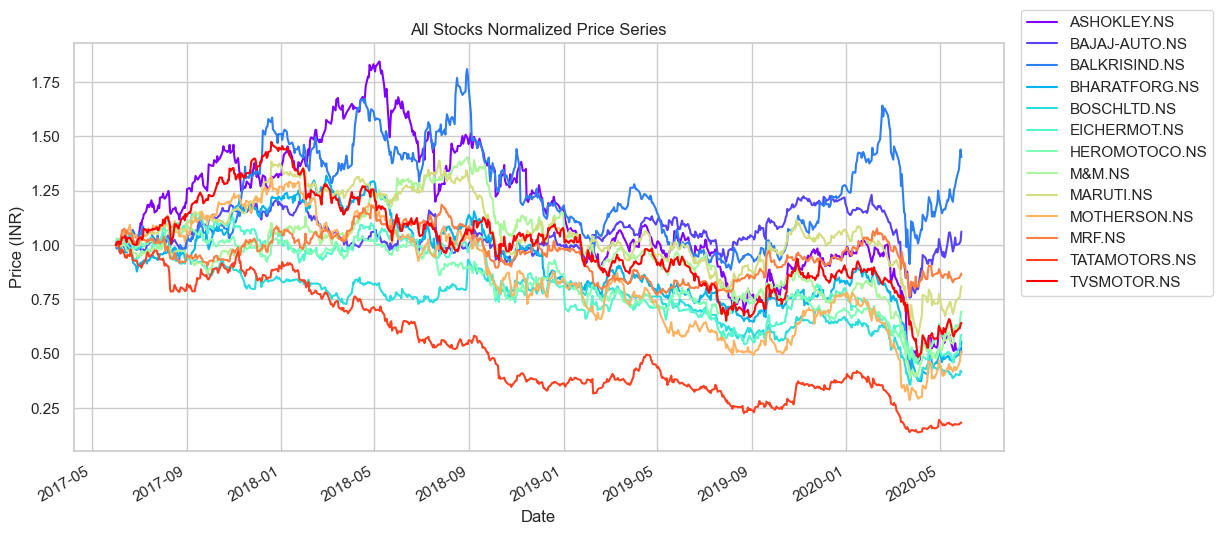

In [48]:
n_secs = len(stock_data.columns)
colors = cm.rainbow(np.linspace(0, 1, n_secs))
stock_data.div(stock_data.iloc[0,:]).plot(color=colors, figsize=(12, 6))# Normalize Prices 
plt.title('All Stocks Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price (INR)')

plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show()

In [49]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = dataframe.columns 
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = dataframe[keys[i]] 
            stock2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(stock1, stock2)
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    return pvalue_matrix, pairs

In [50]:
df = stock_data
binance_symbols = df.columns
pvalue_matrix, pairs = find_cointegrated_pairs(df)

pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

<Axes: >

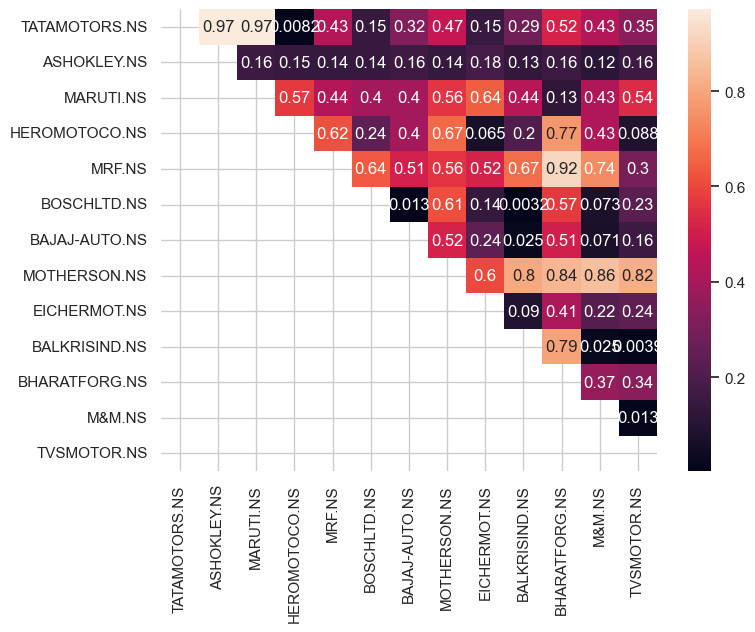

In [51]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalue_matrix_df, xticklabels = stocks, yticklabels = stocks, cmap = 'rocket',  annot = True,mask = (pvalue_matrix_df >= 0.99))

In [52]:
def KalmanFilterAverage(x):

    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
 
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means


def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
   
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

In [53]:
def backtest(df,s1, s2):

    x = df[s1]
    y = df[s2]
  
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    halflife = half_life(df1['spread'])
    
   
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    
    
    # trading logic
    entryZscore = 1
    exitZscore = -0.25
  
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')
    
   
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
  
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1


    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
   
    
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start = pd.Timestamp('2017-01-06')
    end = pd.Timestamp('2020-01-06')
    days = (end - start).days
    CAGR = (end_val / start_val) ** (252.0/days) - 1
    
    df1[s1+ " "+s2+'_cum_rets'] = df1['cum rets']
    
    return df1[s1+ " "+s2+'_cum_rets'], sharpe, CAGR*100,df1

In [54]:
results = []
for pair in pairs:
    rets, sharpe, CAGR,df1 = backtest(stock_data,pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],
                                                                                     round(sharpe,2),
                                                                                     round(CAGR,4)))
    rets0 = pd.concat(results, axis=1)

The pair ASHOKLEY.NS and BHARATFORG.NS produced a Sharpe Ratio of 1.42 and a CAGR of 13.0874
The pair EICHERMOT.NS and HEROMOTOCO.NS produced a Sharpe Ratio of 1.78 and a CAGR of 13.5866
The pair EICHERMOT.NS and MOTHERSON.NS produced a Sharpe Ratio of 0.82 and a CAGR of 9.4274
The pair HEROMOTOCO.NS and MOTHERSON.NS produced a Sharpe Ratio of 1.56 and a CAGR of 15.9352
The pair MOTHERSON.NS and TATAMOTORS.NS produced a Sharpe Ratio of 2.14 and a CAGR of 20.6225
The pair MOTHERSON.NS and TVSMOTOR.NS produced a Sharpe Ratio of 1.32 and a CAGR of 14.6329
The pair TATAMOTORS.NS and TVSMOTOR.NS produced a Sharpe Ratio of 0.85 and a CAGR of 9.4843


Text(0, 0.5, 'Returns')

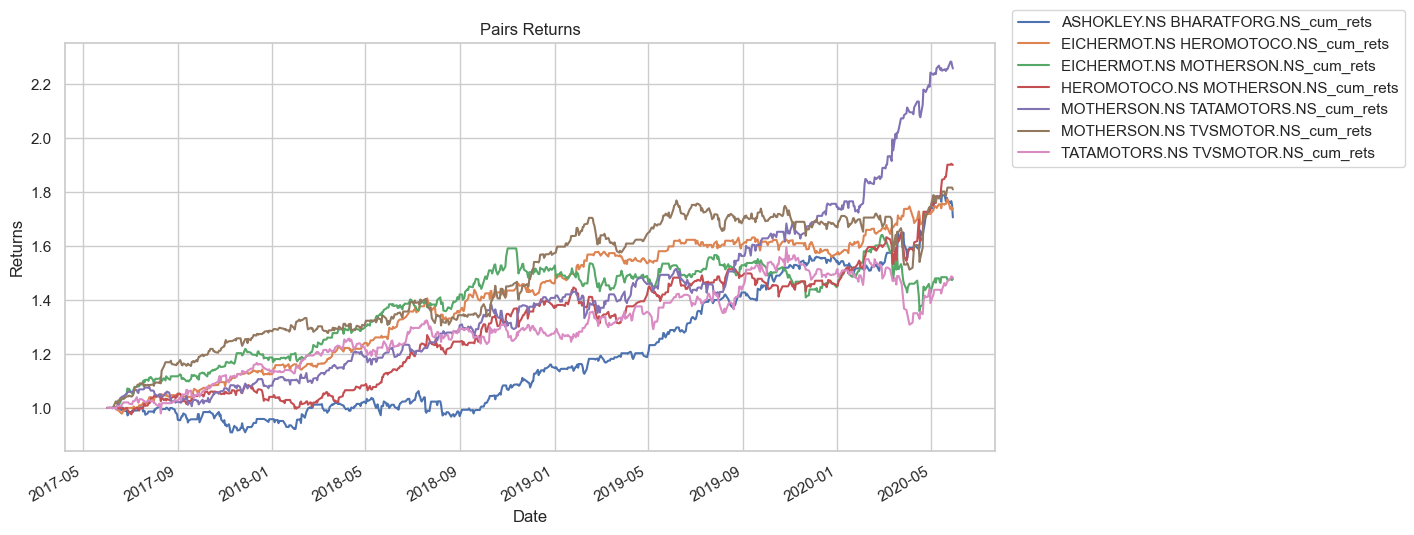

In [55]:
rets0.plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns')

In [56]:
stock_pair = ['MOTHERSON.NS', 'TATAMOTORS.NS']
df_new= yf.download(stock_pair, start="2020-07-01" ,end= "2023-07-01")['Close']
x = df_new[stock_pair[0]]
y = df_new[stock_pair[1]]
    

df_new_2 = pd.DataFrame({'y':y,'x':x})
df_new_2.index = pd.to_datetime(df_new_2.index)
state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
df_new_2['hr'] = - state_means[:,0]
df_new_2['spread'] = df_new_2.y + (df_new_2.x * df_new_2.hr)
halflife = half_life(df_new_2['spread'])

meanSpread = df_new_2.spread.rolling(window=halflife).mean()
stdSpread = df_new_2.spread.rolling(window=halflife).std()
df_new_2['zScore'] = (df_new_2.spread-meanSpread)/stdSpread
    
entryZscore = 1.5 # 2
exitZscore = 0 # 0
df_new_2['long entry'] = ((df_new_2.zScore < - entryZscore) & ( df_new_2.zScore.shift(1) > - entryZscore))
df_new_2['long exit'] = ((df_new_2.zScore > - exitZscore) & (df_new_2.zScore.shift(1) < - exitZscore))
df_new_2['num units long'] = np.nan 
df_new_2.loc[df_new_2['long entry'],'num units long'] = 1 
df_new_2.loc[df_new_2['long exit'],'num units long'] = 0 
df_new_2['num units long'][0] = 0 
df_new_2['num units long'] = df_new_2['num units long'].fillna(method='pad')

#set up num units short 
df_new_2['short entry'] = ((df_new_2.zScore > entryZscore) & ( df_new_2.zScore.shift(1) < entryZscore))
df_new_2['short exit'] = ((df_new_2.zScore < exitZscore) & (df_new_2.zScore.shift(1) > exitZscore))
df_new_2.loc[df_new_2['short entry'],'num units short'] = -1
df_new_2.loc[df_new_2['short exit'],'num units short'] = 0
df_new_2['num units short'][0] = 0
df_new_2['num units short'] = df_new_2['num units short'].fillna(method='pad')
df_new_2.dropna(how="any",inplace=True)
df_new_2['numUnits'] = df_new_2['num units long'] + df_new_2['num units short']
df_new_2['spread pct ch'] = (df_new_2['spread'] - df_new_2['spread'].shift(1)) / ((df_new_2['x'] * abs(df_new_2['hr'])) + df_new_2['y'])
df_new_2['port rets'] = df_new_2['spread pct ch'] * df_new_2['numUnits'].shift(1)
df_new_2['cum rets'] = df_new_2['port rets'].cumsum()
df_new_2['cum rets'] = df_new_2['cum rets'] + 1
df_new_2

[*********************100%***********************]  2 of 2 completed


,y,x,hr,spread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-07-09,105.383636,38.889236,-2.554594,6.037444,-0.074311,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-07-10,106.024109,38.311775,-2.574372,7.395329,0.281725,False,True,0.0,False,False,0.0,0.0,0.006635,0.000000,1.000000
2020-07-13,106.418259,38.271950,-2.592744,7.188884,-0.226996,False,False,0.0,False,True,0.0,0.0,-0.001004,-0.000000,1.000000
2020-07-14,103.609993,37.395794,-2.607749,6.091131,-0.883485,False,False,0.0,False,False,0.0,0.0,-0.005458,-0.000000,1.000000
2020-07-15,101.688553,37.475445,-2.616418,3.637130,-1.783959,True,False,1.0,False,False,0.0,1.0,-0.012286,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23,551.453552,81.668549,-6.768371,-1.309453,-1.028237,False,False,1.0,False,False,0.0,1.0,0.001681,0.001681,1.327678
2023-06-26,559.533386,83.388397,-6.760175,-4.186799,-0.942792,False,False,1.0,False,False,0.0,1.0,-0.002562,-0.002562,1.325117
2023-06-27,564.706482,83.584953,-6.755751,0.027372,-0.444478,False,False,1.0,False,False,0.0,1.0,0.003731,0.003731,1.328848


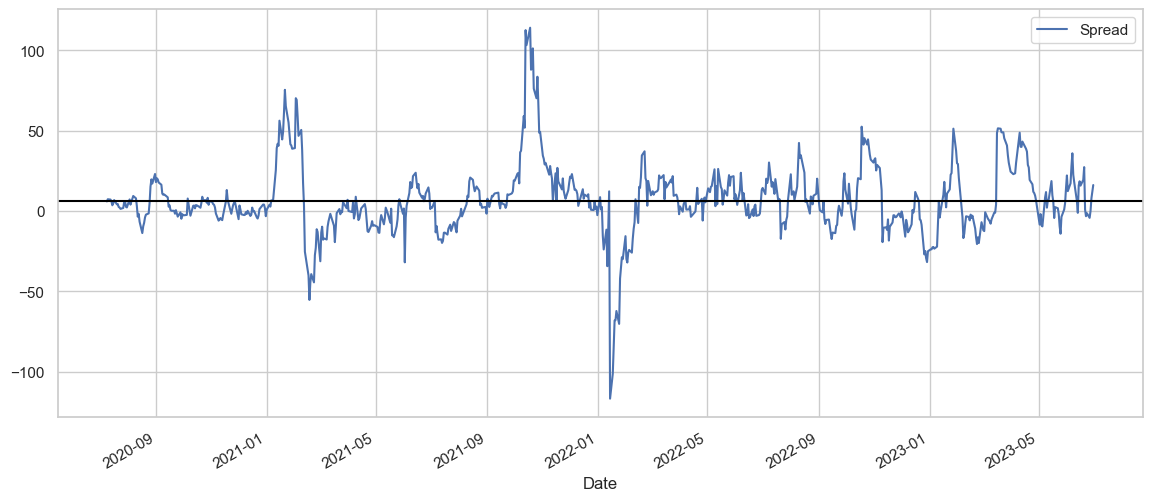

In [57]:
spread = df_new_2["spread"]
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

In [58]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6),dpi=200)
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zScore'], c='#4abdac')
  long_entry = bx.plot(trade_signals['zScore'][trade_signals['long entry'] == True], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  long_exit = bx.plot(trade_signals['zScore'][trade_signals['long exit'] == True], lw = 0, marker = 'v', markersize = 8, c = 'orange', alpha = 0.9)
  short_entry = bx.plot(trade_signals['zScore'][trade_signals["short entry"]== True], lw = 0, marker = '^', markersize = 8, c = 'black', alpha = 0.9)
  short_exit = bx.plot(trade_signals['zScore'][trade_signals["short exit"]== True], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long Entry', 'Long Exit','Short Entry',"Short Exit"])

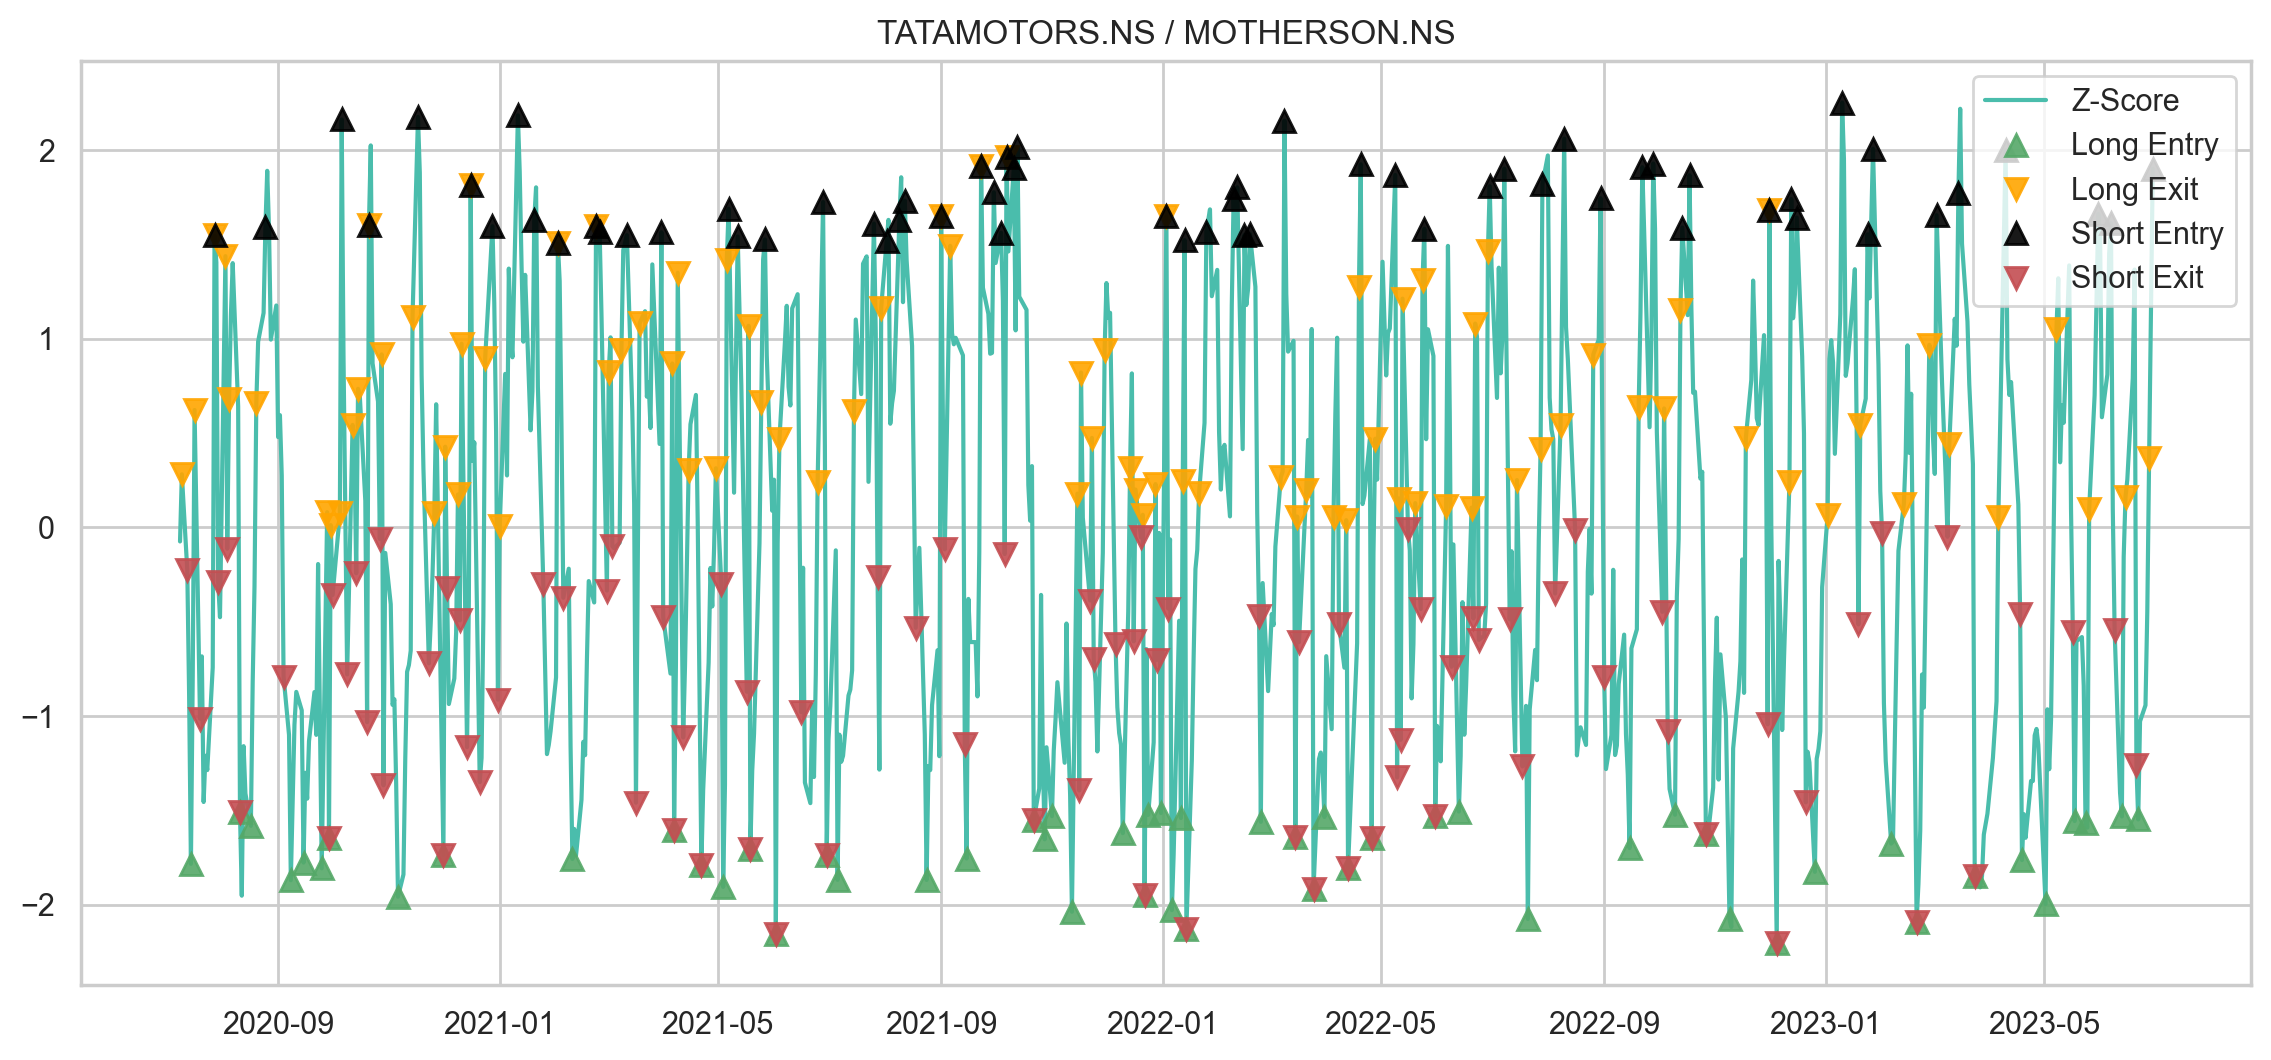

In [59]:
plot_pair_trades(df_new_2)

In [60]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['y'], c='#4abdac')
  u1 = bx.plot(signals['y'][signals['long entry'] == True], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['y'][signals['short entry'] == True], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

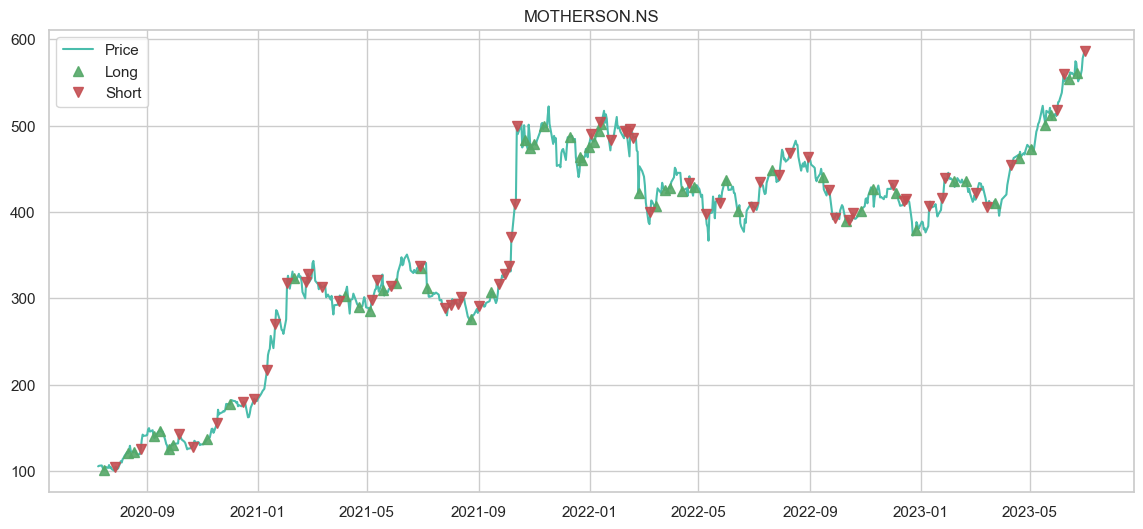

In [61]:
plot_trades_1(df_new_2)

In [62]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['x'], c='#4abdac')
  u1 = bx.plot(signals['x'][signals['long entry'] == True], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['x'][signals['short entry'] == True], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

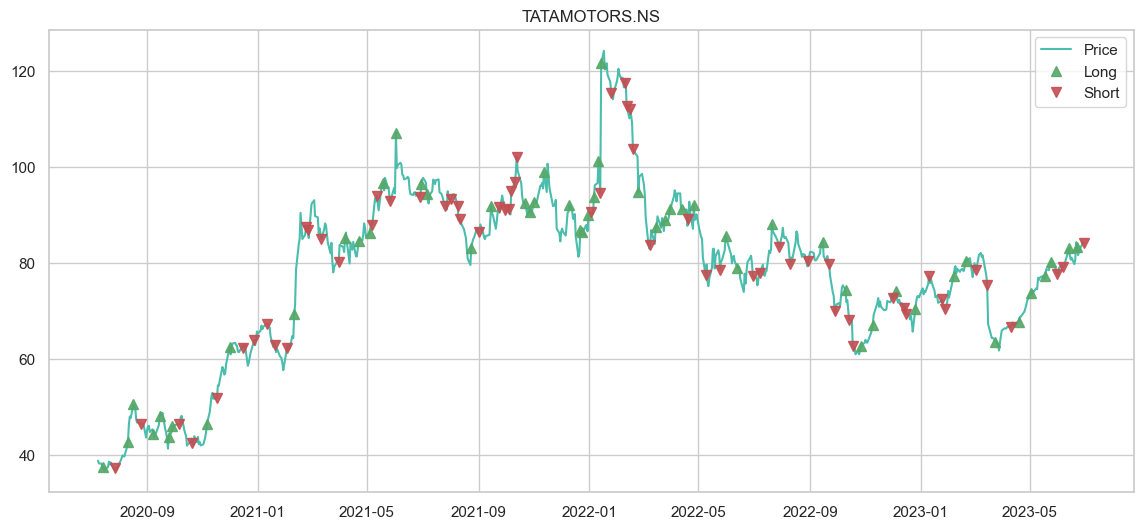

In [63]:
plot_trades_2(df_new_2)

In [64]:
def pnl_calculation(signals):

  initial_capital = 100000


  shares1 = initial_capital// (signals['x'][0])
  shares2 = initial_capital// (signals['y'][0])


  portfolio = pd.DataFrame()
  portfolio['holdings1'] = (signals['long entry']).cumsum() * signals['x'] * shares1
  portfolio['cash1'] = initial_capital - (signals['long entry'] * signals['x'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

 
  portfolio['holdings2'] = signals['long exit'].cumsum() * signals['y'] * shares2
  portfolio['cash2'] = initial_capital - (signals['long exit'] * signals['y'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()


  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [65]:

def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])
     

## Portfolio Performance

In [66]:
plot_portfolio_value(portfolio)

NameError: name 'portfolio' is not defined

## Cumumlative Returns

<Axes: xlabel='Date'>

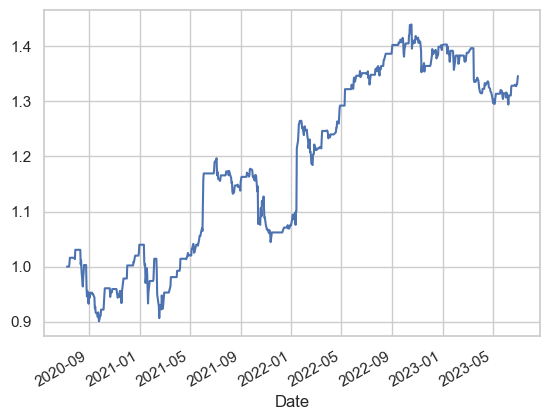

In [ ]:
df_new_2["cum rets"].plot()